In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

In [11]:
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

formatter = FuncFormatter(thousands)

In [ ]:
# Load data``

global_fits = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/04_globalfit_dms_degradation/global_refit_results.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)
fits

# get experimental info
main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
all_kdeg = fits[fits['disp_name'].str.contains('4U_')][['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


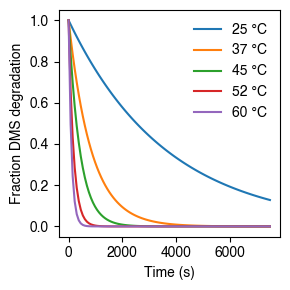

In [12]:

def plot_decay_tc(all_kdeg, temp, ax):
    kdeg_temp = all_kdeg[all_kdeg['temperature'] == temp]
    kdeg_val = np.exp(kdeg_temp['log_kdeg'].mean())

    x_vals = np.linspace(0, 7500, 100)
    y_vals = np.exp(-kdeg_val * x_vals)
    ax.plot(x_vals, y_vals, label = f'{temp} °C')
fig, ax = plt.subplots(figsize=(3, 3))
plot_decay_tc(all_kdeg, 25, ax)
plot_decay_tc(all_kdeg, 37, ax)
plot_decay_tc(all_kdeg, 45, ax)
plot_decay_tc(all_kdeg, 52, ax)
plot_decay_tc(all_kdeg, 60, ax)
ax.legend(frameon = False)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction DMS degradation')
plt.tight_layout()
plt.savefig('dms_globfit_decay.pdf')